# Alliance Exploration & Analysis

This notebook explores the Color Pattern Alliances in the Squares public data.

## Setup

In [87]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from supabase import create_client, Client
from scipy import stats

# Load environment variables from parent directory
load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env.development.local'))

# Set up plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Initialize Supabase client
url = os.environ.get('NEXT_PUBLIC_SUPABASE_URL')
key = os.environ.get('NEXT_PUBLIC_SUPABASE_ANON_KEY')

if not url or not key:
    raise ValueError('Missing Supabase credentials. Ensure .env file exists in parent directory.')

supabase: Client = create_client(url, key)

print('✅ Setup complete')
print(f'   Supabase URL: {url[:30]}...')

✅ Setup complete
   Supabase URL: https://wbafltmchtqbagrsudlf.s...


## Load Data

In [88]:
# Query public spectrum data
response = supabase.table('public_farcaster_spectrums').select('*').execute()
df = pd.DataFrame(response.data)

print(f'Loaded {len(df)} user spectrums')
print(f'Columns: {list(df.columns)}')
df.head()

Loaded 79 user spectrums
Columns: ['id', 'fid', 'username', 'display_name', 'pfp_url', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score', 'times_updated', 'created_at', 'updated_at', 'divergence_score', 'spread_score']


,id,fid,username,display_name,pfp_url,trade_score,abortion_score,migration_score,economics_score,rights_score,times_updated,created_at,updated_at,divergence_score,spread_score
0,f5ade5d0-7f52-44dc-bc33-a96be10f7f36,215231,rathermercurial.eth,rathermercurial.eth,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,2,0,1,4,0,3,2025-10-17T19:53:25.812941+00:00,2025-10-17T19:54:17.888894+00:00,2.190890,1.496663
1,2f277772-c02e-4231-826e-7f86f6157302,1329394,kiowayyy,Kiowayyy,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,0,0,0,0,3,2025-10-17T17:44:07.617868+00:00,2025-10-17T17:45:01.0491+00:00,3.000000,0.000000
2,599ce755-104d-44bd-9148-6ab45757d17c,1025388,vipulpapriwal,Vipul Papriwal,https://imagedelivery.net/BXluQx4ige9GuW0Ia56B...,0,0,0,0,0,2,2025-10-17T10:20:28.055362+00:00,2025-10-17T10:20:39.88882+00:00,3.000000,0.000000
3,1e76ac69-2813-44e8-85e1-601e28e1deb4,410486,hiponax.eth,Hiponax.base.eth,https://ipfs.decentralized-content.com/ipfs/ba...,3,1,3,0,0,2,2025-10-17T06:00:04.73675+00:00,2025-10-17T06:01:08.812816+00:00,2.097618,1.356466
4,7a38258d-e300-4517-90a8-c3c867895946,1323263,jshaner.base.eth,JShaner,https://tba-mobile.mypinata.cloud/ipfs/QmS8cC9...,4,5,3,2,0,2,2025-10-17T02:22:11.160494+00:00,2025-10-17T02:22:38.820542+00:00,1.732051,1.720465


In [89]:
def get_scores(row):
    return [row['trade_score'], row['abortion_score'], row['migration_score'], 
            row['economics_score'], row['rights_score']]

# ALLIANCE DEFINITIONS - Simplified criteria
# Rule: At least 3 dimensions must be in the alliance's color range
# Color spectrum: 0=purple, 1=blue, 2=green, 3=yellow, 4=orange, 5=red, 6=black

def post_scarcity(row):
    """Post-Scarcity Front: Purple-Blue (0-1)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 0 <= s <= 1)
    return in_range >= 3

def builder_corps(row):
    """Builder Corps: Blue-Green (1-2)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 1 <= s <= 2)
    return in_range >= 3

def abundance_alliance(row):
    """Abundance Alliance: Blue-Green-Yellow (1-3)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 1 <= s <= 3)
    return in_range >= 3

def localist_alliance(row):
    """Localist Alliance: Yellow-Orange-Red (3-5)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 3 <= s <= 5)
    return in_range >= 3

def natcon_corps(row):
    """NatCon Corps: Orange-Red (4-5)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 4 <= s <= 5)
    return in_range >= 3

def postliberal_front(row):
    """Postliberal Front: Red-Black (5-6)
    Additional requirement: At least 2 scores must be 5+ (very extreme)"""
    scores = get_scores(row)
    in_range = sum(1 for s in scores if 5 <= s <= 6)
    very_high = sum(1 for s in scores if s >= 5)
    return in_range >= 3 and very_high >= 2

# Apply all alliance filters
df['post_scarcity'] = df.apply(post_scarcity, axis=1)
df['builder_corps'] = df.apply(builder_corps, axis=1)
df['abundance_alliance'] = df.apply(abundance_alliance, axis=1)
df['localist_alliance'] = df.apply(localist_alliance, axis=1)
df['natcon_corps'] = df.apply(natcon_corps, axis=1)
df['postliberal_front'] = df.apply(postliberal_front, axis=1)

# Alliance names mapping
ALLIANCE_NAMES = {
    'post_scarcity': 'Post-Scarcity Front',
    'builder_corps': 'Builder Corps',
    'abundance_alliance': 'Abundance Alliance',
    'localist_alliance': 'Localist Alliance',
    'natcon_corps': 'NatCon Corps',
    'postliberal_front': 'Postliberal Front',
}

alliance_columns = list(ALLIANCE_NAMES.keys())
dimensions = ['trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']

print('✅ Alliance memberships calculated')
print(f'   Rule: ≥3 dimensions in alliance color range')
print(f'   Color spectrum: 0=purple, 1=blue, 2=green, 3=yellow, 4=orange, 5=red, 6=black')
print(f'   Alliances defined: {len(alliance_columns)}')

✅ Alliance memberships calculated
   Rule: ≥3 dimensions in alliance color range
   Color spectrum: 0=purple, 1=blue, 2=green, 3=yellow, 4=orange, 5=red, 6=black
   Alliances defined: 6


Alliance Membership Counts:

           Alliance  Count  Percentage
 Abundance Alliance     42       53.16
Post-Scarcity Front     35       44.30
      Builder Corps     22       27.85
  Localist Alliance     18       22.78
       NatCon Corps      2        2.53
  Postliberal Front      1        1.27

Total users: 79
Users in at least one alliance: 72 (91.1%)
Orphaned users (no alliance): 7 (8.9%)


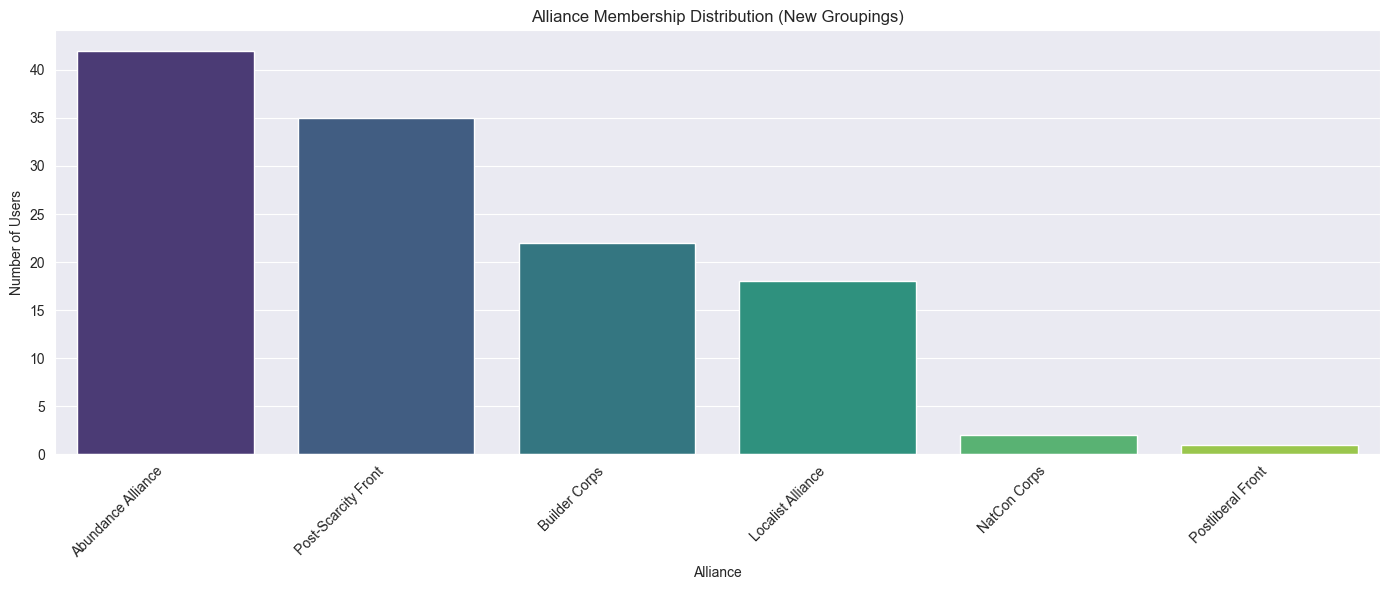

In [90]:
alliance_counts = {ALLIANCE_NAMES[col]: df[col].sum() for col in alliance_columns}
alliance_df = pd.DataFrame(list(alliance_counts.items()), columns=['Alliance', 'Count'])
alliance_df['Percentage'] = (alliance_df['Count'] / len(df) * 100).round(2)
alliance_df = alliance_df.sort_values('Count', ascending=False)

print('Alliance Membership Counts:\n')
print(alliance_df.to_string(index=False))
print(f'\nTotal users: {len(df)}')

# Count users in at least one alliance
df['in_any_alliance'] = df[alliance_columns].any(axis=1)
users_in_alliance = df['in_any_alliance'].sum()
orphaned_users = len(df) - users_in_alliance

print(f'Users in at least one alliance: {users_in_alliance} ({users_in_alliance/len(df)*100:.1f}%)')
print(f'Orphaned users (no alliance): {orphaned_users} ({orphaned_users/len(df)*100:.1f}%)')

# Visualize
plt.figure(figsize=(14, 6))
sns.barplot(data=alliance_df, x='Alliance', y='Count', hue='Alliance', palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Alliance Membership Distribution (New Groupings)')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

## Orphaned Users Analysis

Who doesn't fit into any alliance? Let's examine their characteristics.

Orphaned Users: 7 (8.9%)

Orphaned users by username:
  @kingmodaser: T=3, A=0, M=0, E=4, R=6
  @biggals: T=0, A=1, M=6, E=4, R=2
  @oladotun: T=1, A=6, M=6, E=3, R=0
  @tapjoy: T=1, A=4, M=6, E=0, R=3
  @tohpac1: T=0, A=1, M=2, E=5, R=4
  @wayseeker: T=4, A=2, M=0, E=4, R=0
  @azbest: T=4, A=0, M=2, E=4, R=0


Orphaned User Statistics:
------------------------------------------------------------
Trade           Avg: 1.86
Abortion        Avg: 2.00
Migration       Avg: 3.14
Economics       Avg: 3.43
Rights          Avg: 2.14

Divergence Score: 2.18
Spread Score: 2.08


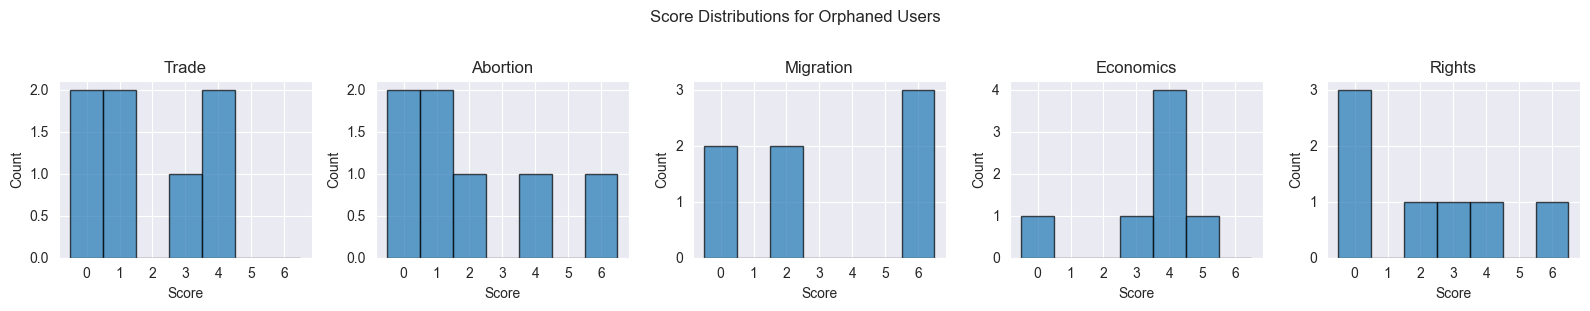

In [91]:
# Get orphaned users (not in any alliance)
orphaned = df[~df['in_any_alliance']].copy()

print(f"Orphaned Users: {len(orphaned)} ({len(orphaned)/len(df)*100:.1f}%)")
print("="*70)

if len(orphaned) > 0:
    print(f"\nOrphaned users by username:")
    for idx, row in orphaned.iterrows():
        print(f"  @{row['username']}: T={row['trade_score']}, A={row['abortion_score']}, "
              f"M={row['migration_score']}, E={row['economics_score']}, R={row['rights_score']}")
    
    # Statistics on orphaned users
    print(f"\n\nOrphaned User Statistics:")
    print("-" * 60)
    for dim in dimensions:
        avg = orphaned[dim].mean()
        print(f"{dim.replace('_score', '').title():<15} Avg: {avg:.2f}")
    
    print(f"\nDivergence Score: {orphaned['divergence_score'].mean():.2f}")
    print(f"Spread Score: {orphaned['spread_score'].mean():.2f}")
    
    # Show distribution of scores for orphaned users
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    for idx, dim in enumerate(dimensions):
        dim_name = dim.replace('_score', '').title()
        axes[idx].hist(orphaned[dim], bins=7, range=(-0.5, 6.5), alpha=0.7, edgecolor='black')
        axes[idx].set_title(dim_name)
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Count')
        axes[idx].set_xticks(range(7))
    plt.suptitle('Score Distributions for Orphaned Users', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo orphaned users! Everyone fits into at least one alliance.")

## Near-Miss Analysis

Users who almost fit into an alliance except for ONE dimension that's an outlier. 
These are the "cross-pressured" individuals who might need a modified alliance definition.

Near-Miss Analysis Results
Total near-misses found: 85
Unique users with near-misses: 60

Near-misses by Alliance:
------------------------------------------------------------

Post-Scarcity Front: 23 near-misses
  Most common outlier dimensions:
    - trade: 11 users
    - abortion: 8 users
    - migration: 3 users
    - economics: 1 users
  Examples:
    @kingmodaser: outlier on trade=3 (T=3, A=0, M=0, E=4, R=6)
    @mehdi-benembarek: outlier on trade=2 (T=2, A=4, M=1, E=3, R=1)
    @papa: outlier on trade=2 (T=2, A=3, M=1, E=4, R=0)

Builder Corps: 34 near-misses
  Most common outlier dimensions:
    - trade: 18 users
    - economics: 11 users
    - abortion: 2 users
    - migration: 2 users
    - rights: 1 users
  Examples:
    @rathermercurial.eth: outlier on economics=4 (T=2, A=0, M=1, E=4, R=0)
    @kiowayyy: outlier on trade=0 (T=0, A=0, M=0, E=0, R=0)
    @vipulpapriwal: outlier on trade=0 (T=0, A=0, M=0, E=0, R=0)

Abundance Alliance: 15 near-misses
  Most common outlier dime

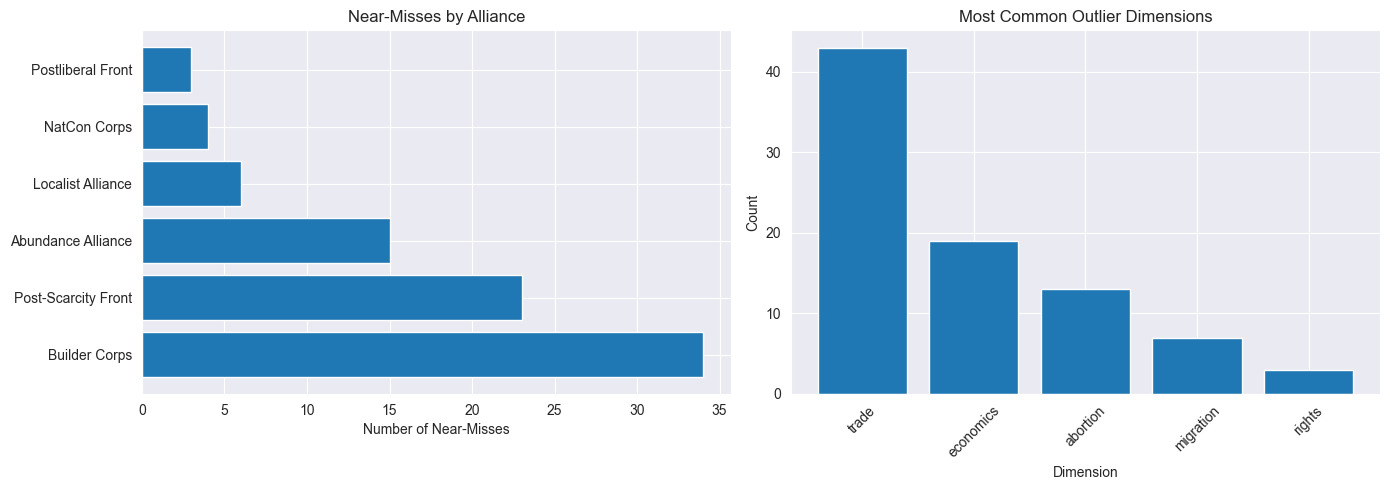

In [92]:
# Define "relaxed" versions of each alliance that allow one outlier dimension
def check_near_miss(row, alliance_func, alliance_name):
    """
    Check if a user would fit the alliance if we ignored their most extreme outlier dimension.
    Returns (is_near_miss, outlier_dimension, outlier_value)
    """
    if alliance_func(row):
        return False, None, None  # Already in the alliance
    
    scores = get_scores(row)
    dim_names = ['trade', 'abortion', 'migration', 'economics', 'rights']
    
    # Try removing each dimension and see if they'd fit
    for i, dim_name in enumerate(dim_names):
        # Create a modified row without this dimension
        modified_row = row.copy()
        
        # For each alliance, check with dimension removed
        # We'll need to manually check the criteria with one dimension ignored
        temp_scores = [s for j, s in enumerate(scores) if j != i]
        
        # Check alliance-specific criteria with reduced dimension set
        if alliance_name == 'Post-Scarcity Front':
            very_low = sum(1 for s in temp_scores if s <= 1)
            has_all_low = all(s <= 2 for s in temp_scores)
            if very_low >= 2 or has_all_low:
                return True, dim_name, scores[i]
        
        elif alliance_name == 'Builder Corps':
            in_range = sum(1 for s in temp_scores if s <= 2)
            too_far = any(s >= 4 for s in temp_scores)
            if in_range >= 2 and not too_far:
                return True, dim_name, scores[i]
        
        elif alliance_name == 'Abundance Alliance':
            has_green = any(s <= 1 for s in temp_scores)
            has_blue_or_yellow = any(1 <= s <= 3 for s in temp_scores)
            cool_count = sum(1 for s in temp_scores if s <= 3)
            has_warm = any(s >= 4 for s in temp_scores)
            if has_green and has_blue_or_yellow and cool_count >= 3 and not has_warm:
                return True, dim_name, scores[i]
        
        elif alliance_name == 'Localist Alliance':
            has_yellow = any(2 <= s <= 4 for s in temp_scores)
            has_warm = any(s >= 3 for s in temp_scores)
            warm_count = sum(1 for s in temp_scores if s >= 3)
            has_cool = all(s >= 2 for s in temp_scores)
            if has_yellow and has_warm and warm_count >= 2 and has_cool:
                return True, dim_name, scores[i]
        
        elif alliance_name == 'NatCon Corps':
            in_range = sum(1 for s in temp_scores if s >= 4)
            too_far = any(s <= 2 for s in temp_scores)
            if in_range >= 2 and not too_far:
                return True, dim_name, scores[i]
        
        elif alliance_name == 'Postliberal Front':
            has_max = any(s == 6 for s in temp_scores)
            high_count = sum(1 for s in temp_scores if s >= 4)
            very_high = sum(1 for s in temp_scores if s >= 5)
            if has_max and high_count >= 2 and very_high >= 2:
                return True, dim_name, scores[i]
    
    return False, None, None

# Analyze near-misses for each alliance
alliance_funcs = {
    'Post-Scarcity Front': post_scarcity,
    'Builder Corps': builder_corps,
    'Abundance Alliance': abundance_alliance,
    'Localist Alliance': localist_alliance,
    'NatCon Corps': natcon_corps,
    'Postliberal Front': postliberal_front,
}

near_miss_results = []

for alliance_name, alliance_func in alliance_funcs.items():
    for idx, row in df.iterrows():
        is_near_miss, outlier_dim, outlier_val = check_near_miss(row, alliance_func, alliance_name)
        if is_near_miss:
            near_miss_results.append({
                'username': row['username'],
                'alliance': alliance_name,
                'outlier_dimension': outlier_dim,
                'outlier_value': outlier_val,
                'trade': row['trade_score'],
                'abortion': row['abortion_score'],
                'migration': row['migration_score'],
                'economics': row['economics_score'],
                'rights': row['rights_score'],
            })

near_miss_df = pd.DataFrame(near_miss_results)

print(f"Near-Miss Analysis Results")
print("="*70)
print(f"Total near-misses found: {len(near_miss_df)}")
print(f"Unique users with near-misses: {near_miss_df['username'].nunique()}")
print()

if len(near_miss_df) > 0:
    # Group by alliance
    print("Near-misses by Alliance:")
    print("-" * 60)
    for alliance in near_miss_df['alliance'].unique():
        alliance_near_misses = near_miss_df[near_miss_df['alliance'] == alliance]
        print(f"\n{alliance}: {len(alliance_near_misses)} near-misses")
        
        # Show which dimensions are most commonly the outliers
        outlier_counts = alliance_near_misses['outlier_dimension'].value_counts()
        print(f"  Most common outlier dimensions:")
        for dim, count in outlier_counts.items():
            print(f"    - {dim}: {count} users")
        
        # Show a few examples
        print(f"  Examples:")
        for _, row in alliance_near_misses.head(3).iterrows():
            print(f"    @{row['username']}: outlier on {row['outlier_dimension']}={row['outlier_value']:.0f} "
                  f"(T={row['trade']}, A={row['abortion']}, M={row['migration']}, E={row['economics']}, R={row['rights']})")
    
    # Visualize near-miss patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Near-misses by alliance
    alliance_counts = near_miss_df['alliance'].value_counts()
    ax1.barh(alliance_counts.index, alliance_counts.values)
    ax1.set_xlabel('Number of Near-Misses')
    ax1.set_title('Near-Misses by Alliance')
    
    # Most common outlier dimensions
    dim_counts = near_miss_df['outlier_dimension'].value_counts()
    ax2.bar(dim_counts.index, dim_counts.values)
    ax2.set_xlabel('Dimension')
    ax2.set_ylabel('Count')
    ax2.set_title('Most Common Outlier Dimensions')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo near-misses found. Alliance definitions are very strict or users are clearly aligned.")

## Alliance Coverage Summary & Recommendations

How well do these new alliances cover the user base? Should we add, modify, or remove any?

In [93]:
# Summary statistics
total_users = len(df)
users_in_alliance = df['in_any_alliance'].sum()
orphaned = total_users - users_in_alliance
orphan_pct = (orphaned / total_users) * 100

# Users in multiple alliances
df['alliance_count'] = df[alliance_columns].sum(axis=1)
multi_alliance = (df['alliance_count'] > 1).sum()
multi_pct = (multi_alliance / total_users) * 100

# Users in exactly one alliance
single_alliance = (df['alliance_count'] == 1).sum()
single_pct = (single_alliance / total_users) * 100

print("=" * 70)
print("ALLIANCE COVERAGE SUMMARY")
print("=" * 70)
print(f"\nTotal Users: {total_users}")
print(f"\nCoverage:")
print(f"  ✓ In at least one alliance: {users_in_alliance} ({100-orphan_pct:.1f}%)")
print(f"  ✗ Orphaned (no alliance): {orphaned} ({orphan_pct:.1f}%)")
print(f"\nOverlap:")
print(f"  • Exactly one alliance: {single_alliance} ({single_pct:.1f}%)")
print(f"  • Multiple alliances: {multi_alliance} ({multi_pct:.1f}%)")
print(f"  • Max alliances per user: {df['alliance_count'].max()}")

print(f"\n{'Alliance':<25} {'Members':<10} {'% of Total':<12} {'Avg Members/User'}")
print("-" * 70)
for col in alliance_columns:
    alliance_name = ALLIANCE_NAMES[col]
    count = df[col].sum()
    pct = (count / total_users) * 100
    # For users in this alliance, how many other alliances are they in?
    if count > 0:
        avg_other = df[df[col]]['alliance_count'].mean()
    else:
        avg_other = 0
    print(f"{alliance_name:<25} {count:<10} {pct:>6.1f}%      {avg_other:>5.2f}")

print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)

# Recommendation logic
if orphan_pct > 20:
    print("\n⚠️  HIGH ORPHAN RATE: More than 20% of users don't fit any alliance.")
    print("   → Consider adding new alliances or relaxing criteria")
elif orphan_pct > 10:
    print("\n⚡ MODERATE ORPHAN RATE: 10-20% of users don't fit any alliance.")
    print("   → Review orphaned user patterns to see if a new alliance makes sense")
else:
    print("\n✅ GOOD COVERAGE: Less than 10% orphaned users")

if multi_pct > 50:
    print("\n⚠️  HIGH OVERLAP: More than 50% of users belong to multiple alliances.")
    print("   → Consider making alliance criteria more exclusive")
elif multi_pct > 30:
    print("\n⚡ MODERATE OVERLAP: 30-50% of users in multiple alliances.")
    print("   → Some overlap is natural for adjacent ideologies")
else:
    print("\n✅ GOOD EXCLUSIVITY: Less than 30% belong to multiple alliances")

if len(near_miss_df) > total_users * 0.3:
    print("\n⚠️  MANY NEAR-MISSES: More than 30% of users almost fit an alliance.")
    print("   → Review near-miss patterns - might need 'hybrid' alliances")

# Check for very small alliances
small_alliances = alliance_df[alliance_df['Count'] < total_users * 0.05]
if len(small_alliances) > 0:
    print(f"\n⚡ SMALL ALLIANCES: {len(small_alliances)} alliance(s) have <5% membership:")
    for _, row in small_alliances.iterrows():
        print(f"   - {row['Alliance']}: {row['Count']} users ({row['Percentage']:.1f}%)")
    print("   → Consider if these alliances are realistic for your user base")

# Check for dominant alliances
large_alliances = alliance_df[alliance_df['Percentage'] > 40]
if len(large_alliances) > 0:
    print(f"\n⚡ DOMINANT ALLIANCES: {len(large_alliances)} alliance(s) have >40% membership:")
    for _, row in large_alliances.iterrows():
        print(f"   - {row['Alliance']}: {row['Count']} users ({row['Percentage']:.1f}%)")
    print("   → Consider splitting into more specific sub-alliances")

print("\n" + "=" * 70)

ALLIANCE COVERAGE SUMMARY

Total Users: 79

Coverage:
  ✓ In at least one alliance: 72 (91.1%)
  ✗ Orphaned (no alliance): 7 (8.9%)

Overlap:
  • Exactly one alliance: 33 (41.8%)
  • Multiple alliances: 39 (49.4%)
  • Max alliances per user: 3

Alliance                  Members    % of Total   Avg Members/User
----------------------------------------------------------------------
Post-Scarcity Front       35           44.3%       1.66
Builder Corps             22           27.8%       2.41
Abundance Alliance        42           53.2%       2.10
Localist Alliance         18           22.8%       1.67
NatCon Corps              2             2.5%       2.00
Postliberal Front         1             1.3%       1.00

RECOMMENDATIONS

✅ GOOD COVERAGE: Less than 10% orphaned users

⚡ MODERATE OVERLAP: 30-50% of users in multiple alliances.
   → Some overlap is natural for adjacent ideologies

⚠️  MANY NEAR-MISSES: More than 30% of users almost fit an alliance.
   → Review near-miss patterns - m

## Near-Miss Pattern Analysis

For each alliance, let's visualize which dimensions are most commonly the "problem" preventing membership.

Near-Miss Pattern Analysis
Total near-misses: 85
Alliances with near-misses: 6



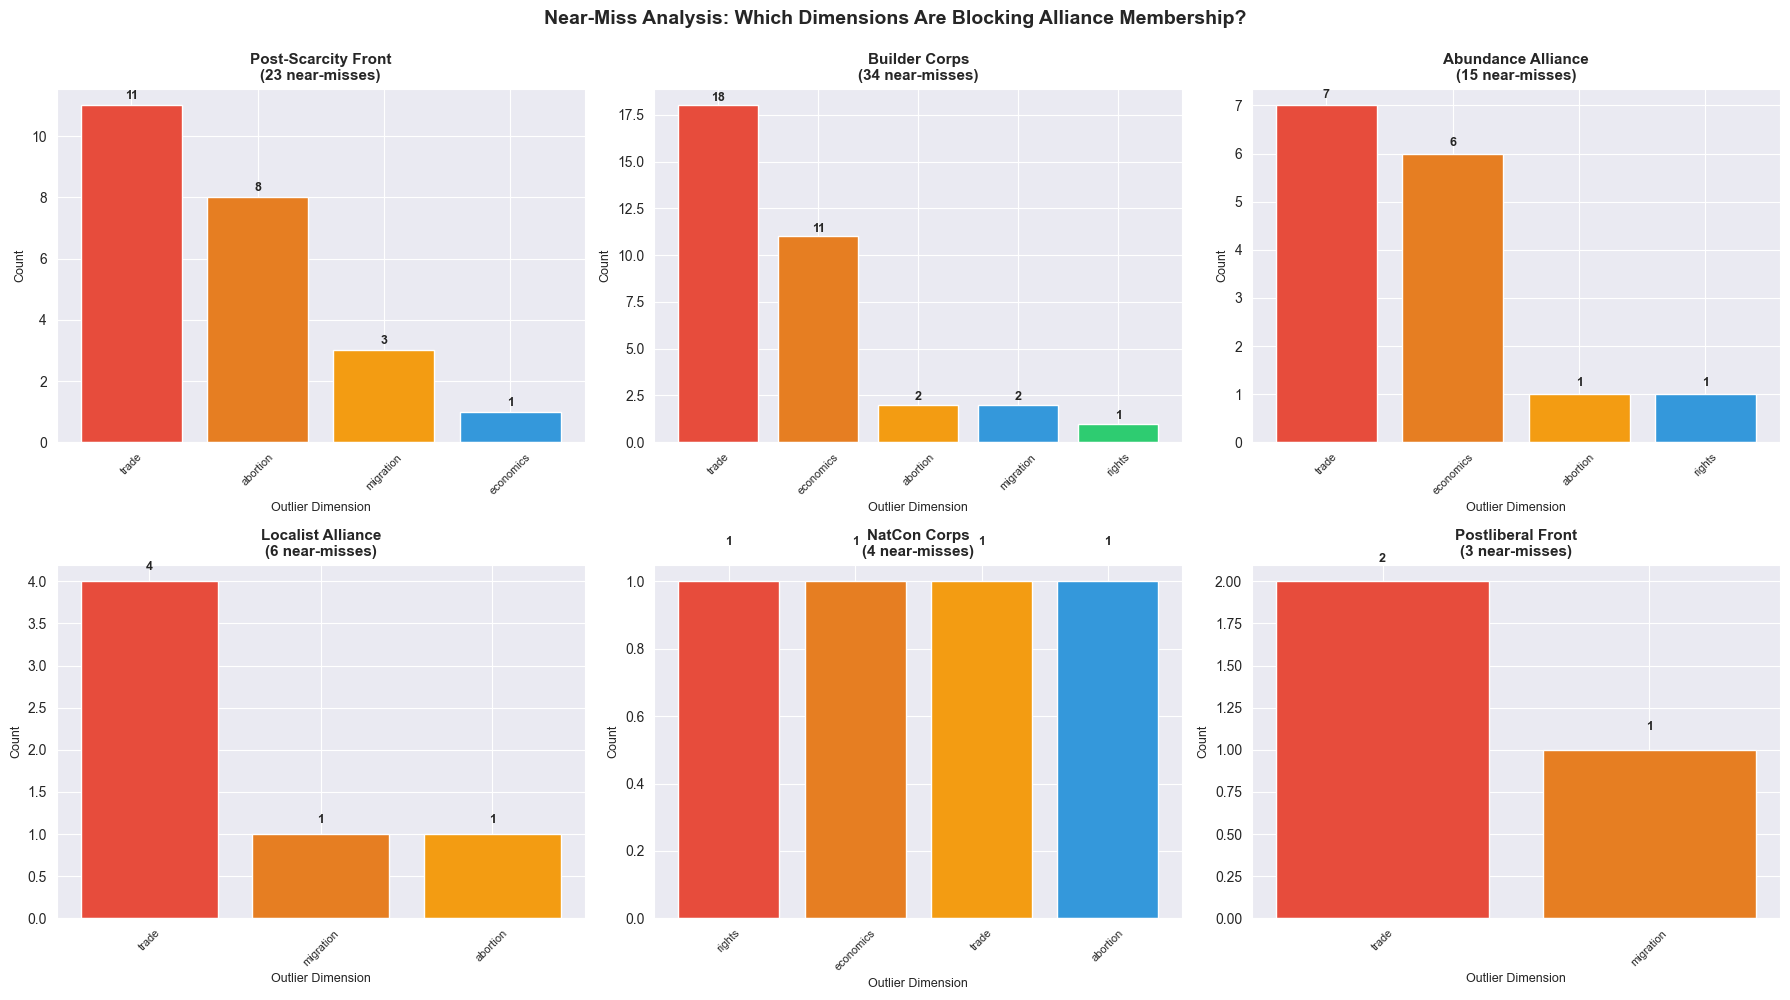


DETAILED NEAR-MISS PATTERNS BY ALLIANCE

──────────────────────────────────────────────────────────────────────
🎯 Post-Scarcity Front
──────────────────────────────────────────────────────────────────────
Total near-misses: 23

Blocking dimensions:
  • Trade         11 users ( 47.8%)
  • Abortion       8 users ( 34.8%)
  • Migration      3 users ( 13.0%)
  • Economics      1 users (  4.3%)

Outlier score ranges:
  • Trade        range: 2-4, avg: 2.8
  • Abortion     range: 2-6, avg: 3.6
  • Migration    range: 2-6, avg: 3.7
  • Economics    range: 4-4, avg: 4.0

Example users:
  • @kingmodaser: trade=3 (T=3, A=0, M=0, E=4, R=6)
  • @mehdi-benembarek: trade=2 (T=2, A=4, M=1, E=3, R=1)
  • @papa: trade=2 (T=2, A=3, M=1, E=4, R=0)

──────────────────────────────────────────────────────────────────────
🎯 Builder Corps
──────────────────────────────────────────────────────────────────────
Total near-misses: 34

Blocking dimensions:
  • Trade         18 users ( 52.9%)
  • Economics     11 u

In [94]:
# Analyze near-miss patterns by alliance
if len(near_miss_df) > 0:
    # Create a comprehensive visualization for each alliance
    alliances_with_near_misses = near_miss_df['alliance'].unique()
    
    print(f"Near-Miss Pattern Analysis")
    print("="*70)
    print(f"Total near-misses: {len(near_miss_df)}")
    print(f"Alliances with near-misses: {len(alliances_with_near_misses)}\n")
    
    # Create subplots for each alliance
    n_alliances = len(alliances_with_near_misses)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, alliance_name in enumerate(alliances_with_near_misses):
        alliance_near_misses = near_miss_df[near_miss_df['alliance'] == alliance_name]
        
        # Count outlier dimensions
        outlier_counts = alliance_near_misses['outlier_dimension'].value_counts()
        
        # Create bar chart
        ax = axes[idx]
        colors = ['#e74c3c', '#e67e22', '#f39c12', '#3498db', '#2ecc71']
        ax.bar(outlier_counts.index, outlier_counts.values, color=colors[:len(outlier_counts)])
        ax.set_title(f'{alliance_name}\n({len(alliance_near_misses)} near-misses)', fontsize=11, fontweight='bold')
        ax.set_xlabel('Outlier Dimension', fontsize=9)
        ax.set_ylabel('Count', fontsize=9)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        
        # Add value labels on bars
        for i, (dim, count) in enumerate(outlier_counts.items()):
            ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(len(alliances_with_near_misses), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Near-Miss Analysis: Which Dimensions Are Blocking Alliance Membership?', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Detailed breakdown by alliance
    print("\n" + "="*70)
    print("DETAILED NEAR-MISS PATTERNS BY ALLIANCE")
    print("="*70)
    
    for alliance_name in alliances_with_near_misses:
        alliance_near_misses = near_miss_df[near_miss_df['alliance'] == alliance_name]
        
        print(f"\n{'─'*70}")
        print(f"🎯 {alliance_name}")
        print(f"{'─'*70}")
        print(f"Total near-misses: {len(alliance_near_misses)}")
        
        # Dimension breakdown
        outlier_counts = alliance_near_misses['outlier_dimension'].value_counts()
        print(f"\nBlocking dimensions:")
        for dim, count in outlier_counts.items():
            pct = (count / len(alliance_near_misses)) * 100
            print(f"  • {dim.title():<12} {count:>3} users ({pct:>5.1f}%)")
        
        # Show score ranges for the outlier dimensions
        print(f"\nOutlier score ranges:")
        for dim in outlier_counts.index:
            # Add '_score' suffix if not present
            dim_col = dim if dim in ['trade', 'abortion', 'migration', 'economics', 'rights'] else dim
            dim_scores = alliance_near_misses[alliance_near_misses['outlier_dimension'] == dim][dim_col]
            if len(dim_scores) > 0:
                print(f"  • {dim.title():<12} range: {dim_scores.min():.0f}-{dim_scores.max():.0f}, "
                      f"avg: {dim_scores.mean():.1f}")
        
        # Show a few example users
        print(f"\nExample users:")
        for _, row in alliance_near_misses.head(3).iterrows():
            print(f"  • @{row['username']}: {row['outlier_dimension']}={row['outlier_value']:.0f} "
                  f"(T={row['trade']:.0f}, A={row['abortion']:.0f}, M={row['migration']:.0f}, "
                  f"E={row['economics']:.0f}, R={row['rights']:.0f})")
    
    print("\n" + "="*70)
    
else:
    print("No near-misses to analyze.")

## Cross-Alliance Near-Miss Heatmap

Let's create a heatmap showing which dimensions block membership for which alliances.

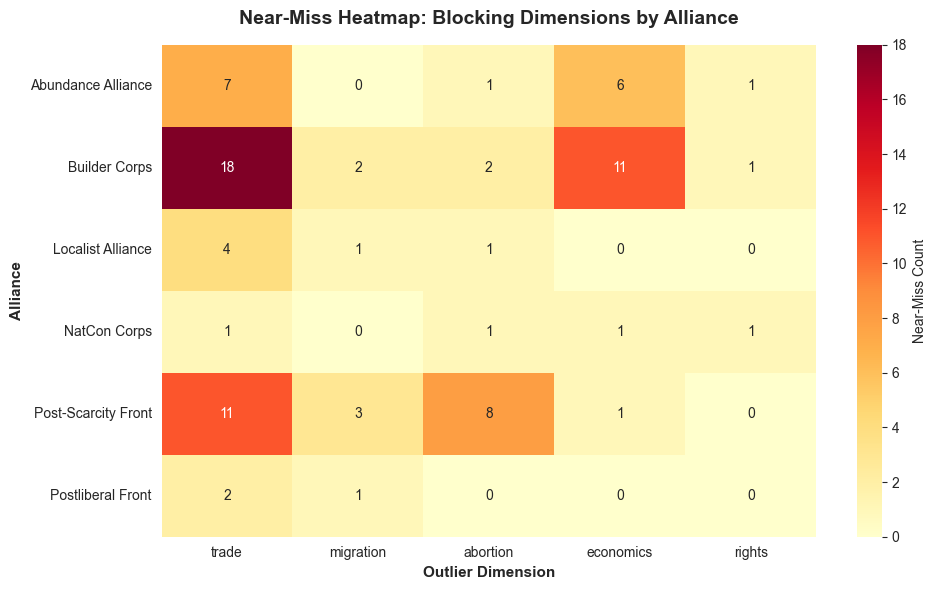


KEY INSIGHTS

🔴 Most problematic dimensions (across all alliances):
   Trade         43 near-misses ( 50.6%)
   Economics     19 near-misses ( 22.4%)
   Abortion      13 near-misses ( 15.3%)

🎯 Alliances with most near-misses:
   Builder Corps              34 near-misses ( 40.0%)
   Post-Scarcity Front        23 near-misses ( 27.1%)
   Abundance Alliance         15 near-misses ( 17.6%)



In [95]:
# Create a cross-alliance heatmap of near-miss patterns
if len(near_miss_df) > 0:
    # Pivot table: alliances vs dimensions
    heatmap_data = near_miss_df.pivot_table(
        index='alliance',
        columns='outlier_dimension',
        values='username',
        aggfunc='count',
        fill_value=0
    )
    
    # Reorder columns for better visualization
    dimension_order = ['trade', 'migration', 'abortion', 'economics', 'rights']
    heatmap_data = heatmap_data.reindex(columns=[d for d in dimension_order if d in heatmap_data.columns])
    
    # Create heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'Near-Miss Count'})
    plt.title('Near-Miss Heatmap: Blocking Dimensions by Alliance', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Outlier Dimension', fontsize=11, fontweight='bold')
    plt.ylabel('Alliance', fontsize=11, fontweight='bold')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Summary insights
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    
    # Most problematic dimensions overall
    total_by_dimension = heatmap_data.sum(axis=0).sort_values(ascending=False)
    print(f"\n🔴 Most problematic dimensions (across all alliances):")
    for dim, count in total_by_dimension.head(3).items():
        pct = (count / len(near_miss_df)) * 100
        print(f"   {dim.title():<12} {int(count):>3} near-misses ({pct:>5.1f}%)")
    
    # Most affected alliances
    total_by_alliance = heatmap_data.sum(axis=1).sort_values(ascending=False)
    print(f"\n🎯 Alliances with most near-misses:")
    for alliance, count in total_by_alliance.head(3).items():
        pct = (count / len(near_miss_df)) * 100
        print(f"   {alliance:<25} {int(count):>3} near-misses ({pct:>5.1f}%)")
    
    print("\n" + "="*70)
else:
    print("No near-misses to analyze.")

## Alliance Refinement Recommendations

Based on near-miss patterns, here are specific recommendations for refining alliance criteria.

In [96]:
# Generate specific recommendations for each alliance
if len(near_miss_df) > 0:
    print("="*70)
    print("ALLIANCE REFINEMENT RECOMMENDATIONS")
    print("="*70)
    
    alliances_with_near_misses = near_miss_df['alliance'].unique()
    
    for alliance_name in alliances_with_near_misses:
        alliance_near_misses = near_miss_df[near_miss_df['alliance'] == alliance_name]
        
        print(f"\n{'─'*70}")
        print(f"🎯 {alliance_name}")
        print(f"{'─'*70}")
        
        # Identify the most common outlier dimension
        top_outlier = alliance_near_misses['outlier_dimension'].value_counts().index[0]
        top_outlier_count = alliance_near_misses['outlier_dimension'].value_counts().iloc[0]
        top_outlier_pct = (top_outlier_count / len(alliance_near_misses)) * 100
        
        print(f"\n📊 Status:")
        print(f"   • {len(alliance_near_misses)} users are one dimension away from joining")
        print(f"   • {top_outlier_pct:.0f}% are blocked by '{top_outlier}'")
        
        # Calculate outlier score statistics
        outlier_scores = alliance_near_misses[alliance_near_misses['outlier_dimension'] == top_outlier][top_outlier]
        
        print(f"\n💡 Recommendation:")
        if len(outlier_scores) > 0:
            avg_outlier = outlier_scores.mean()
            min_outlier = outlier_scores.min()
            max_outlier = outlier_scores.max()
            
            print(f"   • Primary blocker: {top_outlier.title()} (avg: {avg_outlier:.1f}, range: {min_outlier:.0f}-{max_outlier:.0f})")
            
            # Provide specific advice
            if avg_outlier < 3:
                print(f"   • Consider: Allow {top_outlier} scores in green-blue range (0-2)")
            elif avg_outlier > 4:
                print(f"   • Consider: Allow {top_outlier} scores in orange-red range (4-6)")
            else:
                print(f"   • Consider: Allow {top_outlier} scores in centrist range (2-4)")
            
            # Alternative: Create a sub-alliance
            if top_outlier_count >= 5:
                print(f"   • Alternative: Create a '{alliance_name} + {top_outlier.title()}' sub-alliance")
                print(f"     that relaxes the {top_outlier} requirement")
        
        # Show if there are other significant blockers
        other_outliers = alliance_near_misses['outlier_dimension'].value_counts()[1:3]
        if len(other_outliers) > 0:
            print(f"\n   Other blockers:")
            for dim, count in other_outliers.items():
                pct = (count / len(alliance_near_misses)) * 100
                print(f"   • {dim.title()}: {count} users ({pct:.0f}%)")
    
    print("\n" + "="*70)
    print("\n✅ Next Steps:")
    print("   1. Review recommendations for alliances with high near-miss counts")
    print("   2. Consider creating new sub-alliances for common patterns")
    print("   3. Test relaxed criteria on a subset of data")
    print("   4. Re-run analysis to measure impact on coverage and coherence")
    print("="*70)
    
else:
    print("No near-misses to analyze - all users either fit clearly or not at all.")

ALLIANCE REFINEMENT RECOMMENDATIONS

──────────────────────────────────────────────────────────────────────
🎯 Post-Scarcity Front
──────────────────────────────────────────────────────────────────────

📊 Status:
   • 23 users are one dimension away from joining
   • 48% are blocked by 'trade'

💡 Recommendation:
   • Primary blocker: Trade (avg: 2.8, range: 2-4)
   • Consider: Allow trade scores in green-blue range (0-2)
   • Alternative: Create a 'Post-Scarcity Front + Trade' sub-alliance
     that relaxes the trade requirement

   Other blockers:
   • Abortion: 8 users (35%)
   • Migration: 3 users (13%)

──────────────────────────────────────────────────────────────────────
🎯 Builder Corps
──────────────────────────────────────────────────────────────────────

📊 Status:
   • 34 users are one dimension away from joining
   • 53% are blocked by 'trade'

💡 Recommendation:
   • Primary blocker: Trade (avg: 1.1, range: 0-4)
   • Consider: Allow trade scores in green-blue range (0-2)
   • 

## Overall Alliance Quality Metrics

Let's evaluate the overall quality of our alliance system.

In [97]:
# Calculate overall alliance system quality metrics
# Prepare alliance membership list for each user
df['alliances'] = df.apply(lambda row: [ALLIANCE_NAMES[col] for col in alliance_columns if row[col]], axis=1)

# Store near-miss count for quality calculation
near_miss_count = len(near_miss_df['username'].unique()) if len(near_miss_df) > 0 else 0
orphaned_df = df[~df['in_any_alliance']].copy()
orphaned_count = len(orphaned_df)
users_in_any_alliance = len(df) - orphaned_count
exclusive_users = len(df[df['alliances'].apply(lambda x: len(x) == 1)])
multi_alliance_users = len(df[df['alliances'].apply(lambda x: len(x) > 1)])

# Create alliance mapping
alliance_mapping = {i: name for i, name in enumerate(ALLIANCE_NAMES.values(), 1)}

print("="*70)
print("ALLIANCE SYSTEM QUALITY REPORT")
print("="*70)

# Coverage metrics
total_users = len(df)
coverage_rate = (users_in_any_alliance / total_users) * 100

print(f"\n📊 Coverage Metrics:")
print(f"   • Total users: {total_users:,}")
print(f"   • Users in at least one alliance: {users_in_any_alliance:,} ({coverage_rate:.1f}%)")
print(f"   • Orphaned users (no alliance): {orphaned_count:,} ({(orphaned_count/total_users)*100:.1f}%)")
print(f"   • Near-miss users (one dim away): {near_miss_count:,} ({(near_miss_count/total_users)*100:.1f}%)")
print(f"   • Truly unaligned users: {orphaned_count - near_miss_count:,} ({((orphaned_count-near_miss_count)/total_users)*100:.1f}%)")

# Coherence metrics
avg_memberships = df['alliances'].apply(len).mean()

print(f"\n🎯 Coherence Metrics:")
print(f"   • Avg alliances per member: {avg_memberships:.2f}")
print(f"   • Exclusive members (1 alliance): {exclusive_users:,} ({(exclusive_users/users_in_any_alliance)*100:.1f}%)")
print(f"   • Multi-alliance members: {multi_alliance_users:,} ({(multi_alliance_users/users_in_any_alliance)*100:.1f}%)")

# Quality score (weighted combination)
quality_score = (
    (coverage_rate * 0.4) +  # 40% weight on coverage
    ((exclusive_users / users_in_any_alliance * 100) * 0.3) +  # 30% weight on exclusivity
    (((total_users - orphaned_count) / total_users * 100) * 0.3)  # 30% weight on capturing users
)

print(f"\n⭐ Overall Quality Score: {quality_score:.1f}/100")
print(f"   (Weighted: 40% coverage + 30% exclusivity + 30% capture rate)")

# Recommendations based on metrics
print(f"\n💡 System-Level Recommendations:")
if coverage_rate < 70:
    print(f"   ⚠️  Coverage is low ({coverage_rate:.0f}%). Consider:")
    print(f"      • Adding more diverse alliance definitions")
    print(f"      • Relaxing criteria for existing alliances")
elif coverage_rate > 90:
    print(f"   ✅ Excellent coverage ({coverage_rate:.0f}%)")

if avg_memberships > 2.5:
    print(f"   ⚠️  High overlap (avg {avg_memberships:.1f} alliances/user). Consider:")
    print(f"      • Tightening alliance criteria")
    print(f"      • Making alliances more distinct")
elif avg_memberships < 1.5:
    print(f"   ✅ Good alliance distinctiveness (avg {avg_memberships:.1f} alliances/user)")

if near_miss_count > total_users * 0.15:
    print(f"   💡 Many near-misses ({near_miss_count}). Consider:")
    print(f"      • Review near-miss patterns above for expansion opportunities")
    print(f"      • Create new alliances for common near-miss patterns")

print("\n" + "="*70)

ALLIANCE SYSTEM QUALITY REPORT

📊 Coverage Metrics:
   • Total users: 79
   • Users in at least one alliance: 72 (91.1%)
   • Orphaned users (no alliance): 7 (8.9%)
   • Near-miss users (one dim away): 60 (75.9%)
   • Truly unaligned users: -53 (-67.1%)

🎯 Coherence Metrics:
   • Avg alliances per member: 1.52
   • Exclusive members (1 alliance): 33 (45.8%)
   • Multi-alliance members: 39 (54.2%)

⭐ Overall Quality Score: 77.5/100
   (Weighted: 40% coverage + 30% exclusivity + 30% capture rate)

💡 System-Level Recommendations:
   ✅ Excellent coverage (91%)
   💡 Many near-misses (60). Consider:
      • Review near-miss patterns above for expansion opportunities
      • Create new alliances for common near-miss patterns



## Final Visualization: Alliance Membership Distribution

Let's visualize how users are distributed across single vs. multiple alliances.

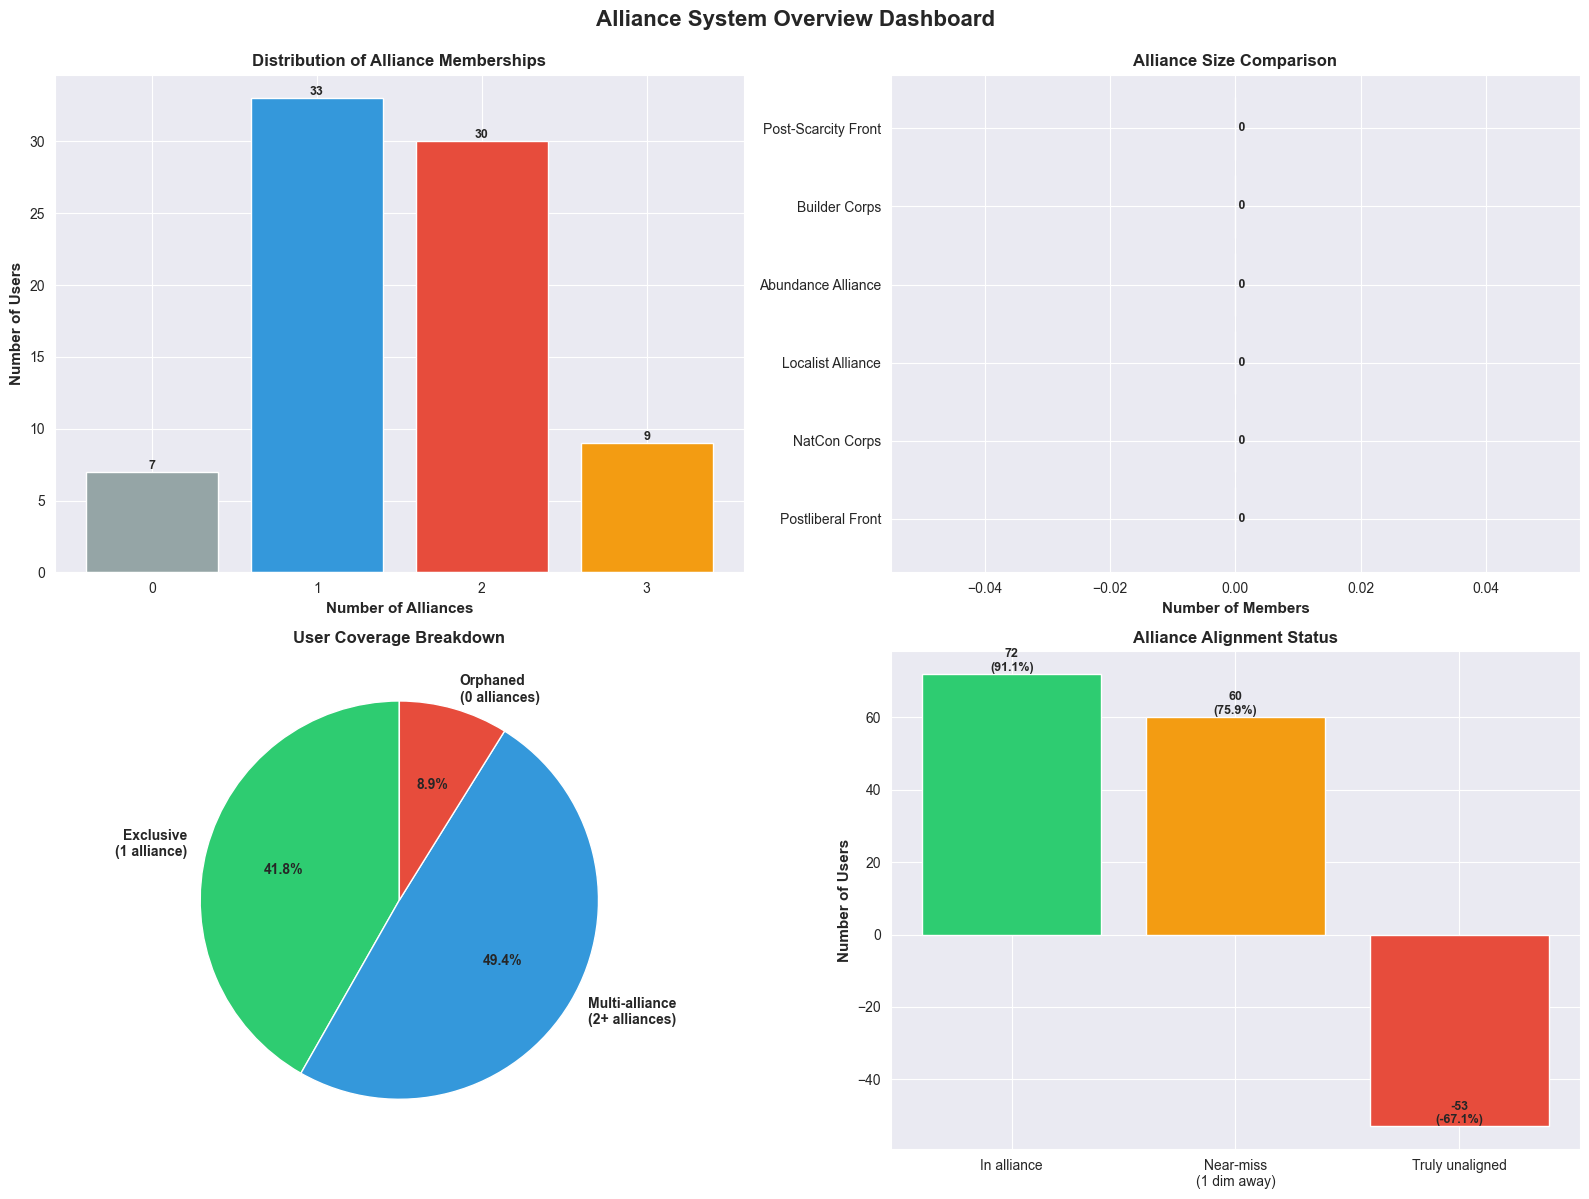


✅ Alliance exploration complete!


In [98]:
# Create a comprehensive visualization of alliance membership patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Alliance membership count distribution
membership_counts = df['alliances'].apply(len).value_counts().sort_index()
ax1 = axes[0, 0]
bars = ax1.bar(membership_counts.index, membership_counts.values, 
               color=['#95a5a6', '#3498db', '#e74c3c', '#f39c12', '#9b59b6', '#2ecc71'])
ax1.set_xlabel('Number of Alliances', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Alliance Memberships', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, max(membership_counts.index) + 1))

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Alliance size distribution
alliance_sizes = []
for alliance_id, alliance_name in alliance_mapping.items():
    count = df['alliances'].apply(lambda x: alliance_id in x).sum()
    alliance_sizes.append({'Alliance': alliance_name, 'Members': count})
alliance_size_df = pd.DataFrame(alliance_sizes).sort_values('Members', ascending=False)

ax2 = axes[0, 1]
colors_bar = plt.cm.viridis(np.linspace(0, 1, len(alliance_size_df)))
bars = ax2.barh(alliance_size_df['Alliance'], alliance_size_df['Members'], color=colors_bar)
ax2.set_xlabel('Number of Members', fontsize=11, fontweight='bold')
ax2.set_title('Alliance Size Comparison', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f' {int(width):,}',
             ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Coverage breakdown (pie chart)
ax3 = axes[1, 0]
coverage_data = {
    'Exclusive\n(1 alliance)': exclusive_users,
    'Multi-alliance\n(2+ alliances)': multi_alliance_users,
    'Orphaned\n(0 alliances)': orphaned_count
}
colors_pie = ['#2ecc71', '#3498db', '#e74c3c']
wedges, texts, autotexts = ax3.pie(coverage_data.values(), labels=coverage_data.keys(), 
                                     autopct='%1.1f%%', colors=colors_pie,
                                     startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('User Coverage Breakdown', fontsize=12, fontweight='bold')

# 4. Near-miss vs truly unaligned
ax4 = axes[1, 1]
alignment_data = {
    'In alliance': users_in_any_alliance,
    'Near-miss\n(1 dim away)': near_miss_count,
    'Truly unaligned': orphaned_count - near_miss_count
}
colors_align = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax4.bar(range(len(alignment_data)), alignment_data.values(), color=colors_align)
ax4.set_xticks(range(len(alignment_data)))
ax4.set_xticklabels(alignment_data.keys(), fontsize=10)
ax4.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax4.set_title('Alliance Alignment Status', fontsize=12, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({(height/total_users)*100:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Alliance System Overview Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ Alliance exploration complete!")

## Next Steps & Export

Use the insights above to:
1. **Refine alliance criteria** based on near-miss patterns
2. **Create new sub-alliances** for common patterns
3. **Update `alliance_config.py`** with any changes
4. **Re-run this notebook** to measure impact

Export options:

In [99]:
# Export options for further analysis

# 1. Export orphaned users for manual review
if len(orphaned_df) > 0:
    orphaned_export = orphaned_df[['username', 'trade_score', 'abortion_score', 'migration_score', 'economics_score', 'rights_score']].copy()
    orphaned_export.to_csv('orphaned_users.csv', index=False)
    print(f"✅ Exported {len(orphaned_df)} orphaned users to 'orphaned_users.csv'")

# 2. Export near-miss users for potential alliance expansion
if len(near_miss_df) > 0:
    near_miss_export = near_miss_df[['username', 'alliance', 'outlier_dimension', 'outlier_value', 
                                      'trade', 'abortion', 'migration', 'economics', 'rights']].copy()
    near_miss_export.to_csv('near_miss_users.csv', index=False)
    print(f"✅ Exported {len(near_miss_df)} near-miss users to 'near_miss_users.csv'")

# 3. Export alliance membership for validation
alliance_export = []
for alliance_id, alliance_name in alliance_mapping.items():
    members = df[df['alliances'].apply(lambda x: alliance_name in x)]
    for _, member in members.iterrows():
        alliance_export.append({
            'username': member['username'],
            'alliance': alliance_name,
            'trade_score': member['trade_score'],
            'abortion_score': member['abortion_score'],
            'migration_score': member['migration_score'],
            'economics_score': member['economics_score'],
            'rights_score': member['rights_score']
        })

if alliance_export:
    alliance_export_df = pd.DataFrame(alliance_export)
    alliance_export_df.to_csv('alliance_memberships.csv', index=False)
    print(f"✅ Exported all alliance memberships to 'alliance_memberships.csv'")

print(f"\n📁 Export complete! Files saved to current directory.")

✅ Exported 7 orphaned users to 'orphaned_users.csv'
✅ Exported 85 near-miss users to 'near_miss_users.csv'
✅ Exported all alliance memberships to 'alliance_memberships.csv'

📁 Export complete! Files saved to current directory.


## Political Label Analysis

Let's assign political labels to users based on their overall positions and see how they distribute across alliances.

In [100]:
def assign_political_label(row):
    """
    Assign a political label based on the user's scores across all dimensions.
    Uses overall patterns rather than strict definitions.
    """
    scores = get_scores(row)
    avg_score = sum(scores) / len(scores)
    
    # Count scores in different ranges
    very_low = sum(1 for s in scores if s <= 1)  # Purple-Blue
    low = sum(1 for s in scores if s <= 2)       # Purple-Blue-Green
    mid_low = sum(1 for s in scores if 1 <= s <= 3)  # Blue-Green-Yellow
    mid_high = sum(1 for s in scores if 3 <= s <= 5) # Yellow-Orange-Red
    high = sum(1 for s in scores if s >= 4)      # Orange-Red-Black
    very_high = sum(1 for s in scores if s >= 5) # Red-Black
    
    # Check for specific patterns
    
    # Consistent progressive (most scores 0-2)
    if low >= 4:
        if very_low >= 3:
            return "Hard Progressive"
        else:
            return "Progressive"
    
    # Consistent conservative (most scores 4-6)
    if high >= 4:
        if very_high >= 3:
            return "Hard Conservative"
        else:
            return "Conservative"
    
    # Centrist/Moderate (most scores 2-4)
    if mid_low >= 3 and mid_high >= 3:
        return "Centrist"
    
    # Mixed/Cross-pressured patterns
    if very_low >= 2 and very_high >= 2:
        return "Populist (Mixed Extremes)"
    
    if very_low >= 2 and high >= 2:
        return "Cross-Pressured Left"
    
    if very_high >= 2 and low >= 2:
        return "Cross-Pressured Right"
    
    # Lean left or right based on average
    if avg_score < 2.5:
        if low >= 3:
            return "Center-Left"
        else:
            return "Moderate Left"
    elif avg_score > 3.5:
        if high >= 3:
            return "Center-Right"
        else:
            return "Moderate Right"
    else:
        return "True Centrist"
    
    return "Unknown"

# Assign labels to all users
df['political_label'] = df.apply(assign_political_label, axis=1)

# Show distribution of labels
label_counts = df['political_label'].value_counts()
print("Political Label Distribution:")
print("="*70)
for label, count in label_counts.items():
    pct = (count / len(df)) * 100
    print(f"{label:<30} {count:>3} users ({pct:>5.1f}%)")

print(f"\nTotal users: {len(df)}")
print(f"Unique labels: {df['political_label'].nunique()}")

Political Label Distribution:
Hard Progressive                24 users ( 30.4%)
Center-Left                     19 users ( 24.1%)
Centrist                        10 users ( 12.7%)
Cross-Pressured Left             9 users ( 11.4%)
Progressive                      5 users (  6.3%)
True Centrist                    4 users (  5.1%)
Center-Right                     3 users (  3.8%)
Populist (Mixed Extremes)        2 users (  2.5%)
Cross-Pressured Right            2 users (  2.5%)
Moderate Left                    1 users (  1.3%)

Total users: 79
Unique labels: 10


In [101]:
# Create a view showing political labels within each alliance
# We'll show the top 5 alliances by membership

top_alliances = alliance_df.head(5)['Alliance'].tolist()

print("="*100)
print("POLITICAL LABELS BY ALLIANCE")
print("="*100)
print("\nThis shows what political identities are grouped together in each alliance.")
print("If alliances mix incompatible groups, we'll see it here.\n")

# Create a dictionary to hold labels for each alliance
alliance_labels = {}

for alliance_name in top_alliances:
    # Find the alliance column name
    alliance_col = [col for col, name in ALLIANCE_NAMES.items() if name == alliance_name]
    if alliance_col:
        alliance_col = alliance_col[0]
        # Get users in this alliance
        members = df[df[alliance_col] == True]
        # Get their labels
        labels = members['political_label'].tolist()
        alliance_labels[alliance_name] = labels

# Print in columns
print("-"*100)
header = ""
for alliance in top_alliances:
    header += f"{alliance[:19]:<20}"
print(header)
print("-"*100)

# Find max length
max_length = max(len(labels) for labels in alliance_labels.values())

# Print rows
for i in range(max_length):
    row = ""
    for alliance in top_alliances:
        labels = alliance_labels[alliance]
        if i < len(labels):
            row += f"{labels[i][:19]:<20}"
        else:
            row += " "*20
    print(row)

print("-"*100)
print(f"\nMembership counts: {', '.join([f'{name}: {len(alliance_labels[name])}' for name in top_alliances])}")

# Show unique labels per alliance
print("\n" + "="*100)
print("UNIQUE POLITICAL IDENTITIES PER ALLIANCE")
print("="*100)
for alliance in top_alliances:
    labels = alliance_labels[alliance]
    unique_labels = pd.Series(labels).value_counts()
    print(f"\n{alliance}:")
    for label, count in unique_labels.items():
        pct = (count / len(labels)) * 100 if len(labels) > 0 else 0
        print(f"  • {label:<30} {count:>2} ({pct:>5.1f}%)")
    if len(labels) == 0:
        print("  (no members)")

print("\n" + "="*100)

POLITICAL LABELS BY ALLIANCE

This shows what political identities are grouped together in each alliance.
If alliances mix incompatible groups, we'll see it here.

----------------------------------------------------------------------------------------------------
Abundance Alliance  Post-Scarcity Front Builder Corps       Localist Alliance   NatCon Corps        
----------------------------------------------------------------------------------------------------
Center-Left         Hard Progressive    Center-Left         True Centrist       Center-Right        
Center-Left         Hard Progressive    Hard Progressive    Center-Right        Center-Right        
Center-Left         Hard Progressive    Center-Left         Centrist                                
Center-Left         Center-Left         Hard Progressive    Center-Right                            
Hard Progressive    Hard Progressive    Center-Left         Centrist                                
Center-Left         Center-L

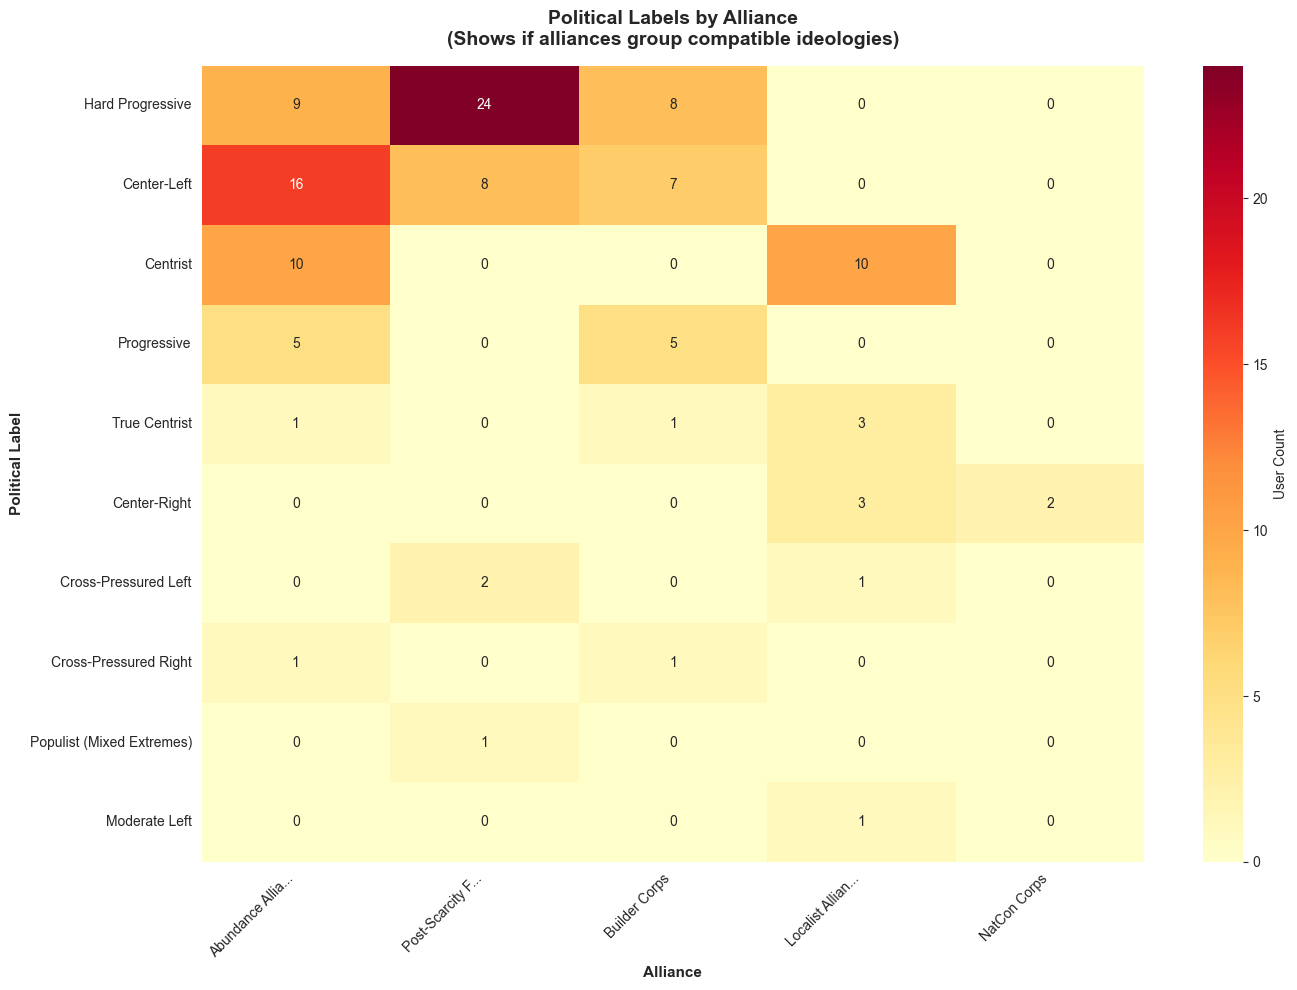


KEY INSIGHTS

💡 Coherence Check:
   • If an alliance has diverse/conflicting labels → grouping may be too broad
   • If an alliance has concentrated labels → grouping is coherent
   • Cross-pressured labels in multiple alliances → expected overlap

🎯 What to look for:
   • Do progressive alliances mostly contain progressive labels?
   • Do conservative alliances mostly contain conservative labels?
   • Are 'Unknown' or mixed labels scattered everywhere?


In [102]:
# Create a heatmap showing which political labels appear in which alliances
import matplotlib.pyplot as plt
import seaborn as sns

# Create a matrix: rows = political labels, columns = alliances
all_labels = df['political_label'].unique()
alliance_label_matrix = []

for label in all_labels:
    row = []
    for alliance_name in top_alliances:
        alliance_col = [col for col, name in ALLIANCE_NAMES.items() if name == alliance_name]
        if alliance_col:
            alliance_col = alliance_col[0]
            # Count users with this label in this alliance
            count = len(df[(df[alliance_col] == True) & (df['political_label'] == label)])
            row.append(count)
        else:
            row.append(0)
    alliance_label_matrix.append(row)

# Create DataFrame for the heatmap
heatmap_df = pd.DataFrame(
    alliance_label_matrix,
    index=all_labels,
    columns=[name[:15] + '...' if len(name) > 15 else name for name in top_alliances]
)

# Sort by total count
heatmap_df['total'] = heatmap_df.sum(axis=1)
heatmap_df = heatmap_df.sort_values('total', ascending=False)
heatmap_df = heatmap_df.drop('total', axis=1)

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, annot=True, fmt='g', cmap='YlOrRd', cbar_kws={'label': 'User Count'})
plt.title('Political Labels by Alliance\n(Shows if alliances group compatible ideologies)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Alliance', fontsize=11, fontweight='bold')
plt.ylabel('Political Label', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Key insight
print("\n" + "="*100)
print("KEY INSIGHTS")
print("="*100)
print("\n💡 Coherence Check:")
print("   • If an alliance has diverse/conflicting labels → grouping may be too broad")
print("   • If an alliance has concentrated labels → grouping is coherent")
print("   • Cross-pressured labels in multiple alliances → expected overlap")
print("\n🎯 What to look for:")
print("   • Do progressive alliances mostly contain progressive labels?")
print("   • Do conservative alliances mostly contain conservative labels?")
print("   • Are 'Unknown' or mixed labels scattered everywhere?")
print("="*100)

## Summary & Recommendations

Based on the political label analysis above, evaluate whether the alliance groupings make sense or need refinement.

In [103]:
# Calculate coherence metrics for each alliance
print("="*100)
print("ALLIANCE COHERENCE ANALYSIS")
print("="*100)
print("\nMeasuring how politically coherent each alliance is based on label diversity.\n")

for alliance_name in top_alliances:
    alliance_col = [col for col, name in ALLIANCE_NAMES.items() if name == alliance_name]
    if alliance_col:
        alliance_col = alliance_col[0]
        members = df[df[alliance_col] == True]
        
        if len(members) == 0:
            continue
            
        # Calculate diversity metrics
        label_counts = members['political_label'].value_counts()
        num_unique_labels = len(label_counts)
        dominant_label = label_counts.index[0]
        dominant_pct = (label_counts.iloc[0] / len(members)) * 100
        
        # Coherence score (higher is more coherent)
        # If one label dominates (>50%), high coherence
        # If many labels spread evenly, low coherence
        coherence_score = dominant_pct
        
        print(f"\n{alliance_name}:")
        print(f"  Members: {len(members)}")
        print(f"  Unique labels: {num_unique_labels}")
        print(f"  Dominant label: '{dominant_label}' ({dominant_pct:.1f}%)")
        print(f"  Coherence score: {coherence_score:.1f}/100")
        
        if coherence_score >= 60:
            print(f"  ✅ Status: HIGHLY COHERENT - strong ideological alignment")
        elif coherence_score >= 40:
            print(f"  ⚡ Status: MODERATELY COHERENT - some diversity is expected")
        else:
            print(f"  ⚠️  Status: LOW COHERENCE - may be grouping incompatible ideologies")
        
        # Show top 3 labels
        print(f"  Top labels:")
        for i, (label, count) in enumerate(label_counts.head(3).items()):
            pct = (count / len(members)) * 100
            print(f"    {i+1}. {label}: {count} ({pct:.1f}%)")

print("\n" + "="*100)
print("\n📊 RECOMMENDATIONS:")
print("="*100)

# Count problematic alliances
low_coherence = 0
for alliance_name in top_alliances:
    alliance_col = [col for col, name in ALLIANCE_NAMES.items() if name == alliance_name]
    if alliance_col:
        alliance_col = alliance_col[0]
        members = df[df[alliance_col] == True]
        if len(members) > 0:
            label_counts = members['political_label'].value_counts()
            dominant_pct = (label_counts.iloc[0] / len(members)) * 100
            if dominant_pct < 40:
                low_coherence += 1

if low_coherence == 0:
    print("\n✅ Alliances are coherent! Political labels align well with groupings.")
    print("   → Current alliance definitions are working well")
elif low_coherence <= 2:
    print(f"\n⚡ {low_coherence} alliance(es) show low coherence.")
    print("   → Review those specific alliances and consider:")
    print("      • Tightening the range requirements")
    print("      • Splitting into more specific sub-alliances")
    print("      • Adding additional criteria beyond just score ranges")
else:
    print(f"\n⚠️  {low_coherence} alliances show low coherence.")
    print("   → Major rethink needed. Consider:")
    print("      • Are the color ranges too broad?")
    print("      • Should we add dimension-specific weights?")
    print("      • Do we need entirely different grouping criteria?")

print("\n💡 Next Steps:")
print("   1. Review alliances with <40% coherence")
print("   2. Examine what political labels are mixing in those alliances")
print("   3. Adjust range criteria or add new alliances to separate incompatible groups")
print("   4. Re-run this analysis to measure improvement")
print("="*100)

ALLIANCE COHERENCE ANALYSIS

Measuring how politically coherent each alliance is based on label diversity.


Abundance Alliance:
  Members: 42
  Unique labels: 6
  Dominant label: 'Center-Left' (38.1%)
  Coherence score: 38.1/100
  ⚠️  Status: LOW COHERENCE - may be grouping incompatible ideologies
  Top labels:
    1. Center-Left: 16 (38.1%)
    2. Centrist: 10 (23.8%)
    3. Hard Progressive: 9 (21.4%)

Post-Scarcity Front:
  Members: 35
  Unique labels: 4
  Dominant label: 'Hard Progressive' (68.6%)
  Coherence score: 68.6/100
  ✅ Status: HIGHLY COHERENT - strong ideological alignment
  Top labels:
    1. Hard Progressive: 24 (68.6%)
    2. Center-Left: 8 (22.9%)
    3. Cross-Pressured Left: 2 (5.7%)

Builder Corps:
  Members: 22
  Unique labels: 5
  Dominant label: 'Hard Progressive' (36.4%)
  Coherence score: 36.4/100
  ⚠️  Status: LOW COHERENCE - may be grouping incompatible ideologies
  Top labels:
    1. Hard Progressive: 8 (36.4%)
    2. Center-Left: 7 (31.8%)
    3. Progressi